In [1]:
#%%time
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick

from scipy.io import loadmat
from scipy.interpolate import spline
from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.cluster import KMeans

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input, ZeroPadding2D,merge,Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.optimizers import SGD
from keras import backend as K
from keras.engine import Layer
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from keras.layers.core import  Lambda
from keras.regularizers import l2
import cv2
#}

Using Theano backend.


In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        img = cv2.imread(im_path)
        #print im_path
        #print img.shape
        if img_size:
            img = cv2.resize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [4]:
def preprocess_image(image_paths, image_height=224, image_width=224,color_mode='rgb'):
    """resize images to the appropriate dimensions
    :param image_width:
    :param image_height:
    :param image: image
    :return: image
    """
    img_list = []
    
    for im_path in image_paths:
        image = cv2.imread(im_path)
        image = cv2.resize(image, (image_height, image_width))
        
        image = image.astype('float32')
        image[:, :, 0] -= 123.68
        image[:, :, 1] -= 116.779
        image[:, :, 2] -= 103.939
        if color_mode == 'bgr':
            image = image.transpose((2, 0, 1))
        
        img_list.append(image)
        
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')
    return img_batch

In [5]:
#Helper function to normalization across channels
K.set_image_dim_ordering('th')
def crosschannelnormalization(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        if K.image_dim_ordering()=='tf':
            b, r, c, ch = X.get_shape()
        else:
            b, ch, r, c = X.shape

        half = n // 2
        square = K.square(X)
        scale = k
        if K.image_dim_ordering() == 'th':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0,0),(half,half)))
            extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
            for i in range(n):
                scale += alpha * extra_channels[:, i:i+ch, :, :]
        if K.image_dim_ordering() == 'tf':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 3, 1, 2)), (half, 0))
            extra_channels = K.permute_dimensions(extra_channels, (0, 2, 3, 1))
            for i in range(n):
                scale += alpha * extra_channels[:, :, :, i:i+int(ch)]
        scale = scale ** beta
        return X / scale


    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [6]:
#Helper Function to split tensor
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = K.shape(X)[axis] // ratio_split

        if axis == 0:
            output = X[id_split*div:(id_split+1)*div, :, :, :]
        elif axis == 1:
            output = X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:, :, id_split*div:(id_split+1)*div, :]
        elif axis == 3:
            output = X[:, :, :, id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")
        return output

    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)


    return Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

In [7]:
#Alexnet layer architecture class
def AlexNet(img_shape=(3, 227, 227), n_classes=1000, l2_reg=0.,weights_path=None, lambda_mask=None):

    dim_ordering = K.image_dim_ordering()
    print(dim_ordering)
    if dim_ordering == 'th':
        batch_index = 0
        channel_index = 1
        row_index = 2
        col_index = 3
    if dim_ordering == 'tf':
        batch_index = 0
        channel_index = 3
        row_index = 1
        col_index = 2
        
    
    inputs = Input(img_shape)

    conv_1 = Convolution2D(96, 11, 11, subsample=(4, 4), activation='relu',
                           name='conv_1', W_regularizer=l2(l2_reg))(inputs)

    if lambda_mask is not None:
        conv_1_mask  = np.reshape(lambda_mask[0:290400], (96,55,55))
    else:
        conv_1_mask = np.ones(shape=((96, 55, 55)))
    
    conv_1_mask  = K.variable(conv_1_mask)
    conv_1_lambda = Lambda(lambda x: x * conv_1_mask)(conv_1)

    conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1_lambda)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Convolution2D(128, 5, 5, activation="relu", name='conv_2_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_2")

    if lambda_mask is not None:
        conv_2_mask  = np.reshape(lambda_mask[290400:477024],(256, 27, 27) )
    else:
        conv_2_mask = np.ones(shape=((256, 27, 27)))
        
    conv_2_mask = K.variable(conv_2_mask)
    conv_2_lambda = Lambda(lambda x: x * conv_2_mask)(conv_2)

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2_lambda)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Convolution2D(384, 3, 3, activation='relu', name='conv_3',
                           W_regularizer=l2(l2_reg))(conv_3)

    if lambda_mask is not None:
        conv_3_mask  = np.reshape(lambda_mask[477024:541920],(384, 13, 13))
    else:
        conv_3_mask = np.ones(shape=((384, 13, 13)))
    
    conv_3_mask = K.variable(conv_3_mask)
    conv_3_lambda = Lambda(lambda x: x * conv_3_mask)(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3_lambda)
    conv_4 = merge([
        Convolution2D(192, 3, 3, activation="relu", name='conv_4_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_4")

    if lambda_mask is not None:
        conv_4_mask  = np.reshape(lambda_mask[541920:606816],(384, 13, 13))
    else:
        conv_4_mask = np.ones(shape=((384, 13, 13)))
        
    conv_4_mask = K.variable(conv_4_mask)
    conv_4_lambda = Lambda(lambda x: x * conv_4_mask)(conv_4)

    conv_5 = ZeroPadding2D((1, 1))(conv_4_lambda)
    conv_5 = merge([
        Convolution2D(128, 3, 3, activation="relu", name='conv_5_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_5")

    if lambda_mask is not None:
        conv_5_mask  = np.reshape(lambda_mask[606816:650080],(256, 13, 13))
    else:
        conv_5_mask = np.ones(shape=((256, 13, 13)))
    
    conv_5_mask = K.variable(conv_5_mask)
    conv_5_lambda = Lambda(lambda x: x * conv_5_mask)(conv_5)

    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name="convpool_5")(conv_5_lambda)

    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1',
                    W_regularizer=l2(l2_reg))(dense_1)

    if lambda_mask is not None:
        dense_1_mask  = np.reshape(lambda_mask[650080:654176],(4096,))
    else:
        dense_1_mask = np.ones(shape=((4096,)))
    
    
    dense_1_mask = K.variable(dense_1_mask)
    dense_1_lambda = Lambda(lambda x: x * dense_1_mask)(dense_1)

    dense_2 = Dropout(0.5)(dense_1_lambda)
    dense_2 = Dense(4096, activation='relu', name='dense_2',
                    W_regularizer=l2(l2_reg))(dense_2)

    if lambda_mask is not None:
        dense_2_mask  = np.reshape(lambda_mask[654176:658272],(4096,))
    else:
        dense_2_mask = np.ones(shape=((4096,)))
    
    dense_2_mask = K.variable(dense_2_mask)
    dense_2_lambda = Lambda(lambda x: x * dense_2_mask)(dense_2)

    dense_3 = Dropout(0.5)(dense_2_lambda)
    if n_classes == 1000:
        dense_3 = Dense(n_classes, name='dense_3',
                        W_regularizer=l2(l2_reg))(dense_3)
    else:
        # We change the name so when loading the weights_file from a
        # Imagenet pretrained model does not crash
        dense_3 = Dense(n_classes, name='dense_3_new',
                        W_regularizer=l2(l2_reg))(dense_3)


    prediction = Activation("softmax", name="softmax")(dense_3)

    model = Model(input=inputs, output=prediction)
    if weights_path:
        model.load_weights(weights_path)

    return model

In [8]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids


In [9]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [10]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error


In [11]:
#Testing on test data{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test.pkl','rb') as f:
    X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test.pkl','rb') as f:
    y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl/kmeans_first_test.pickle'):
    with open('../../data/pkl/kmeans_first_test.pickle',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=65827,
                             random_state=0,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_


#DO CLUSTERING AND GET CLUSTERS

#from sklearn.cluster import KMeans
#from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#import genieclust
#import hdbscan
import smm

j = 23 #Set this value from scree plot!
method = 'gmm'
print(j, len(X_new))
#clf = hdbscan.HDBSCAN(min_cluster_size=j, gen_min_span_tree=True)
#clf = DBSCAN(eps=3.443)
#clf = KMeans(n_clusters=j)
#clf= SpectralClustering(n_clusters=j,random_state=143)
#clf =  AgglomerativeClustering(n_clusters=j, linkage='single')
#clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
clf = GaussianMixture(n_components=j, covariance_type='full',max_iter=1000, random_state=42)
#clf= genieclust.genie.Genie(n_clusters=j)
#clf= smm.SMM(n_components=j, covariance_type='full', tol=1e-12,min_covar=1e-6, n_iter=1000, n_init=1, params='wmcd', init_params='wmcd')
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
#y_pred = clf.fit_predict(X_new)
print(set(y_pred))

for label in set(y_pred):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    #pred = clf.fit_predict(X_new)
    #temp = clf.fit(X_new)
    pred = clf.predict(X_new)
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((658272,)))
    print(len(loc_new),' out of 658272')
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
    model.compile(optimizer=sgd, loss='mse')

    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
        with open(image_list_valid,'rb') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image(im_valid_test,227,227, color_mode="bgr")
        out = model.predict(im_temp,batch_size=64)
        
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error

    result[label] = dprime

(23, 65827)
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
('Cluster: ', 23, 'Label: ', 0)
(87077, ' out of 658272')
th
animate 0 39 1.0 0.0
inanimate 21 39 0.461538461538 0.538461538462
('Cluster: ', 23, 'Label: ', 1)
(5450, ' out of 658272')
th
animate 30 39 0.230769230769 0.769230769231
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 2)
(16754, ' out of 658272')
th
animate 31 39 0.205128205128 0.794871794872
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 3)
(404, ' out of 658272')
th
animate 33 39 0.153846153846 0.846153846154
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 4)
(1031, ' out of 658272')
th
animate 31 39 0.205128205128 0.794871794872
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 5)
(8040, ' out of 658272')
th
animate 33 39 0.153846153846 0.846153846154
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Lab

(array([   25,    38,    45, ..., 65789, 65794, 65814]), 87077)


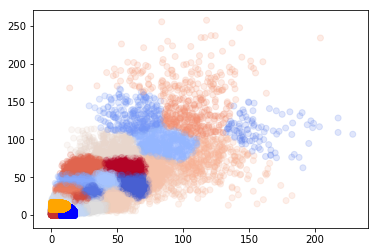

In [12]:
ana = int(result.values().index(max(result.values())))
ina = int(result.values().index(min(result.values())))
pred = clf.predict(X_new)
pred_proba = clf.predict_proba(X_new)
loc = np.where(pred==ana)
loc_temp = kmeans.predict(X_new[loc[0]])
loc_new =[]
for entry in set(loc_temp):
    temp = np.where(pred_kmeans==entry)[0]
    loc_new.extend(temp)
          
print(loc[0],len(loc_new))
plt.scatter(X_new[:,0],X_new[:,1],c=pred,cmap='coolwarm',alpha=0.2)
X_ana =  X_new[np.where(pred==ana)[0]]
X_ina = X_new[np.where(pred==ina)[0]]
plt.scatter(X_ana[:,0],X_ana[:,1],c='b')
plt.scatter(X_ina[:,0],X_ina[:,1],c='orange')

In [15]:
print(label)

22


In [16]:
result.values(),X.shape

([0.5384615384615384,
  -0.15384615384615385,
  -0.1794871794871794,
  -0.23076923076923073,
  -0.1794871794871794,
  -0.23076923076923073,
  -0.23076923076923073,
  -0.15384615384615385,
  -0.5641025641025641,
  0.33333333333333337,
  -0.4358974358974358,
  -0.1794871794871794,
  -0.20512820512820507,
  -0.15384615384615385,
  -0.23076923076923073,
  -0.1794871794871794,
  -0.20512820512820507,
  -0.1794871794871794,
  -0.28205128205128205,
  -0.20512820512820507,
  -0.15384615384615385,
  0.0,
  -0.23076923076923073],
 (658272, 2))

In [17]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((658272,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

(65827, 65827)


In [18]:
X.shape, z.shape

((658272, 2), (658272,))

In [19]:
x = X[:,0]
y = X[:,1]

In [20]:
print result.values().index(max(result.values())), result.values().index(min(result.values()))
ana = int(result.values().index(max(result.values())))
ina = int(result.values().index(min(result.values())))
print result[ana], -1*(result[ina])

0 8
0.538461538462 0.564102564103


70789
(0, 70789)


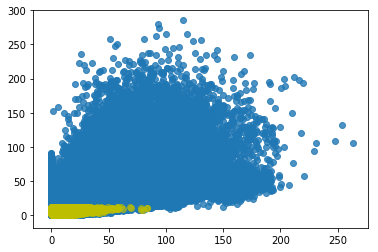

In [21]:
temp = []
for p in loc[0]:
    temp.append(pred_proba[p][ana])
sorted_temp = sorted(range(len(temp)), key=lambda k: temp[k])
import math
eff =int(math.ceil(float(len(sorted_temp)*0.75)))
loc_select = loc[0][sorted_temp[0:eff]] 

loc_temp = kmeans.predict(X_new[loc_select])
loc_new =[]
for entry in set(loc_temp):
    temp = np.where(pred_kmeans==entry)[0]
    loc_new.extend(temp)
print(len(loc_new))
R = X[loc_new]
print(len(spax),len(R))
plt.scatter(X[:,0],X[:,1],alpha=0.8)
plt.scatter(R[:,0],R[:,1],c='y',alpha=0.6)
#plt.scatter(spax,spay,c='green')

In [22]:
spax = []
spay = []
spix = []
spiy = []
for i in range(0,len(z)):
    if z[i] == result[ana]:
        spax.append(x[i])
        spay.append(y[i])
    elif z[i] == result[ina]:
        spix.append(x[i])
        spiy.append(y[i])
spax = np.asarray(spax)
spay = np.asarray(spay)
spix = np.asarray(spix)
spiy = np.asarray(spiy)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

((658272,), (658272,), (658272,))


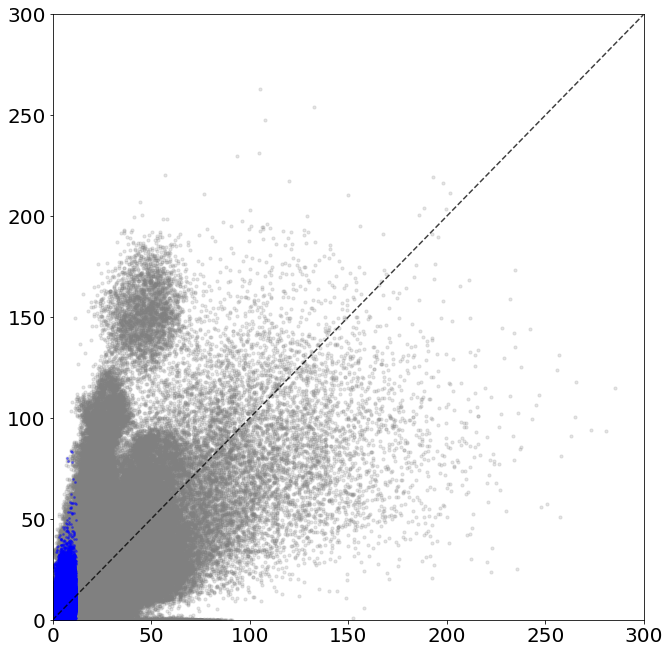

In [34]:
#Density Plot for Animate/Inanimate

print(x.shape,y.shape,z.shape)
fig, ax = plt.subplots(figsize=(9,9))
cs =  ax.scatter( y,x, s=10,c='grey', alpha=0.2)
#cs = ax.scatter( x,y, s=10,c=z,cmap='coolwarm',vmin=-1, vmax=1,alpha=0.6)
#confidence_ellipse(spax, spay, ax, edgecolor='red',n_std=3)
#confidence_ellipse(spix, spiy, ax, edgecolor='blue',n_std=3)
#plt.tricontour(x, y, z,cmap='coolwarm')

m = plt.cm.ScalarMappable(cmap='coolwarm')
m.set_array(x)
m.set_clim(-1., 1.)
#plt.colorbar(m, boundaries=np.linspace(-1.,1., len(x)),orientation='horizontal')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
#ax.scatter(spiy,spix,c='C1',s=3, alpha=0.4)
ax.scatter(spay,spax,c='b',s=3, alpha=0.4)
#ax.scatter(X_ana[:,0],X_ana[:,1],c='b')
#ax.scatter(X_ina[:,0],X_ina[:,1],c='C1')
ax.plot(lims, lims, 'k--', alpha=0.75)
plt.xlim([0,300])
plt.ylim([0,300])
#plt.xlabel('Animate')
#plt.ylabel('Inanimate')
#plt.title('Performance Impact - Scatter plot')
plt.tight_layout()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.savefig('../../results/'+str(method)+'_aresults_density.png', format='png',dpi=500, bbox_inches = "tight")

In [24]:
import gc
#keras.backend.clear_session()
gc.collect()
del model

In [25]:
# Load the pretrained model and make the guided backprop operator
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5")
model.compile(optimizer=sgd, loss='mse')

th


In [26]:
#Actual Model - Cluster Lesioned
label=ana
print(label,result[label])
pred = clf.predict(X_new)
loc = np.where(pred==label)
loc_temp = kmeans.predict(X_new[loc[0]])
loc_new =[]
for entry in set(loc_temp):
    temp = np.where(pred_kmeans==entry)[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((658272,)))
print(len(loc_new),' out of 658272')
lambda_mask[loc_new] = 0.
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
model.compile(optimizer=sgd, loss='mse')

(0, 0.5384615384615384)
(87077, ' out of 658272')
th


In [27]:
print(im_valid_test)

['../../data/inanimate/ILSVRC2012_val_00003274.JPEG', '../../data/inanimate/ILSVRC2012_val_00003534.JPEG', '../../data/inanimate/ILSVRC2012_val_00026921.JPEG', '../../data/inanimate/ILSVRC2012_val_00034555.JPEG', '../../data/inanimate/ILSVRC2012_val_00022306.JPEG', '../../data/inanimate/ILSVRC2012_val_00035826.JPEG', '../../data/inanimate/ILSVRC2012_val_00019723.JPEG', '../../data/inanimate/ILSVRC2012_val_00019679.JPEG', '../../data/inanimate/ILSVRC2012_val_00026183.JPEG', '../../data/inanimate/ILSVRC2012_val_00011312.JPEG', '../../data/inanimate/ILSVRC2012_val_00000737.JPEG', '../../data/inanimate/ILSVRC2012_val_00022973.JPEG', '../../data/inanimate/ILSVRC2012_val_00015074.JPEG', '../../data/inanimate/ILSVRC2012_val_00010518.JPEG', '../../data/inanimate/ILSVRC2012_val_00001572.JPEG', '../../data/inanimate/ILSVRC2012_val_00029155.JPEG', '../../data/inanimate/ILSVRC2012_val_00040940.JPEG', '../../data/inanimate/ILSVRC2012_val_00002081.JPEG', '../../data/inanimate/ILSVRC2012_val_00005545

In [28]:
image_list_valid = '../../data/pkl/inanimate_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))
        
im_temp = preprocess_image(im_valid_test,227,227, color_mode="bgr")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_valid_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_valid_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

print len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test)
print count, error
c=0
w=0
flag  = 0
for i in range(len(true_valid_wids)):
    flag  = 0
    temp = true_valid_wids[i]
    for j in predicted_valid_wids[i][0:5]:
        if j == temp:
            flag = 1
            break
    if flag == 1:
        c +=1
        print(i,'1 - Correct')
    else:
        w+=1
        print(i,'0 - Wrong')
print(c,w)

39 39 39
21 0.461538461538
(0, '1 - Correct')
(1, '1 - Correct')
(2, '0 - Wrong')
(3, '1 - Correct')
(4, '0 - Wrong')
(5, '1 - Correct')
(6, '0 - Wrong')
(7, '1 - Correct')
(8, '0 - Wrong')
(9, '0 - Wrong')
(10, '1 - Correct')
(11, '0 - Wrong')
(12, '1 - Correct')
(13, '1 - Correct')
(14, '1 - Correct')
(15, '1 - Correct')
(16, '0 - Wrong')
(17, '0 - Wrong')
(18, '0 - Wrong')
(19, '0 - Wrong')
(20, '1 - Correct')
(21, '1 - Correct')
(22, '1 - Correct')
(23, '0 - Wrong')
(24, '1 - Correct')
(25, '0 - Wrong')
(26, '1 - Correct')
(27, '0 - Wrong')
(28, '0 - Wrong')
(29, '1 - Correct')
(30, '1 - Correct')
(31, '1 - Correct')
(32, '0 - Wrong')
(33, '1 - Correct')
(34, '0 - Wrong')
(35, '1 - Correct')
(36, '1 - Correct')
(37, '0 - Wrong')
(38, '0 - Wrong')
(21, 18)


In [ ]:
'''
Without lesion

(0, '1 - Correct')
(1, '1 - Correct')
(2, '0 - Wrong')
(3, '1 - Correct')
(4, '0 - Wrong')
(5, '1 - Correct')
(6, '0 - Wrong')
(7, '0 - Wrong')
(8, '0 - Wrong')
(9, '1 - Correct')
(10, '0 - Wrong')
(11, '0 - Wrong')
(12, '1 - Correct')
(13, '0 - Wrong')
(14, '0 - Wrong')
(15, '1 - Correct')
(16, '1 - Correct')
(17, '0 - Wrong')
(18, '1 - Correct')
(19, '0 - Wrong')
(20, '1 - Correct')
(21, '1 - Correct')
(22, '1 - Correct')
(23, '0 - Wrong')
(24, '0 - Wrong')
(25, '1 - Correct')
(26, '1 - Correct')
(27, '1 - Correct')
(28, '0 - Wrong')
(29, '1 - Correct')
(30, '0 - Wrong')
(31, '1 - Correct')
(32, '1 - Correct')
(33, '1 - Correct')
(34, '1 - Correct')
(35, '0 - Wrong')
(36, '1 - Correct')
(37, '0 - Wrong')
(38, '0 - Wrong')
21,18
'''

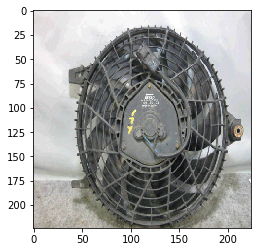

In [29]:
from keras.preprocessing.image import load_img, img_to_array
image_name = im_valid_test[36]
_img = load_img(image_name,target_size=(224,224))
plt.imshow(_img)

In [30]:
import json
CLASS_INDEX = json.load(open("../../data/imagenet_class_index.json"))
classlabel = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

N of class=1000


In [31]:
img               = preprocess_image_batch([image_name],img_size=(227,227))[0]
y_pred            = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
topNclass         = 5
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred[0,idx]))

Top 1 predicted class:     Pr(Class=electric_fan       [index=545])=0.112
Top 2 predicted class:     Pr(Class=digital_watch      [index=531])=0.024
Top 3 predicted class:     Pr(Class=magnetic_compass   [index=635])=0.024
Top 4 predicted class:     Pr(Class=disk_brake         [index=535])=0.023
Top 5 predicted class:     Pr(Class=stopwatch          [index=826])=0.022


In [32]:
from vis.utils import utils
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'softmax')

# The code above is essentially doing:
#for i, layer in enumerate(model.layers):
#    print("{:2.0f} {:10}".format(i, layer.name))
#    if "predictions" in layer.name:
#        layer_idx = i

In [33]:
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
#model = utils.apply_modifications(model)

In [34]:
from vis.visualization import visualize_saliency
class_idx = class_idxs_sorted[0]
grad_top1 = visualize_saliency(model,
                               layer_idx,
                               filter_indices = class_idx,
                               seed_input     = img[np.newaxis,...])

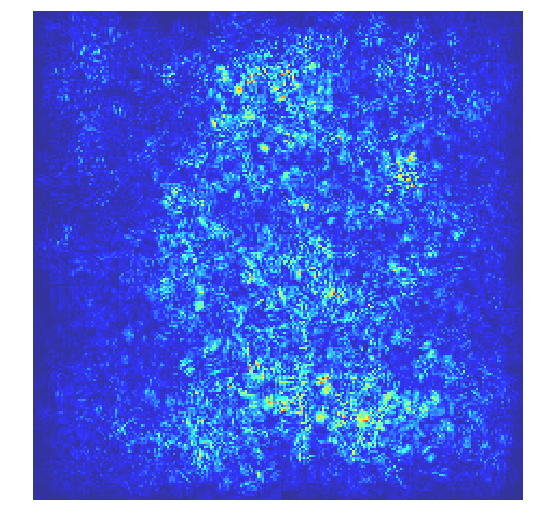

In [35]:
def plot_map(grads):
    fig, axes = plt.subplots(1,1,figsize=(9,9))
    #axes.imshow(_img)
    #axes[1].imshow(_img)
    i = axes.imshow(grads,cmap="jet",alpha=0.8)
    #fig.colorbar(i)
    #plt.suptitle("Pr(class={}) = {:5.2f}".format(classlabel[class_idx],y_pred[0,class_idx]))

plot_map(grad_top1)
plt.axis('off')
plt.savefig('../../results/lesion_animate_cluster_inanimate_incorrect.png', type='png', dpi=500)

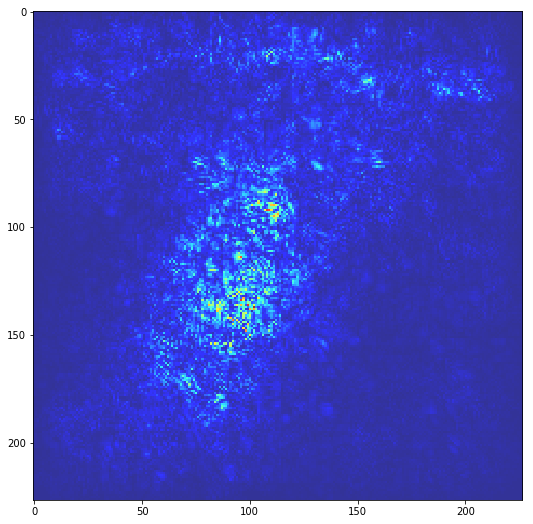

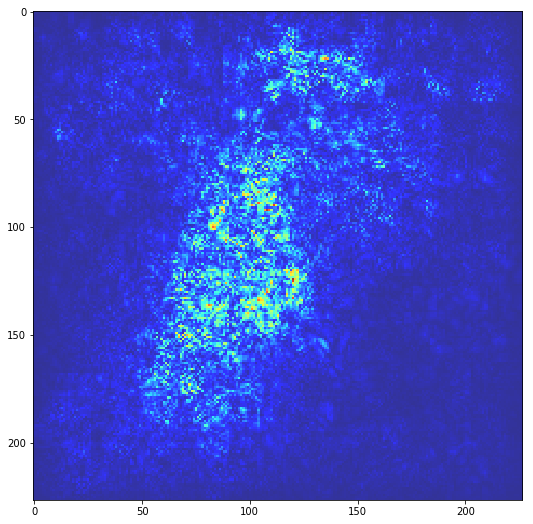

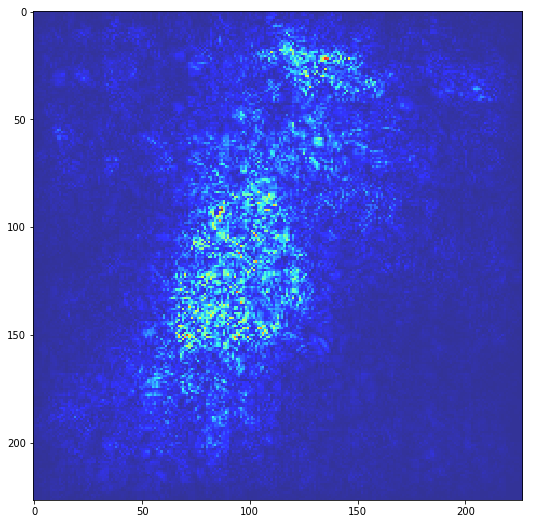

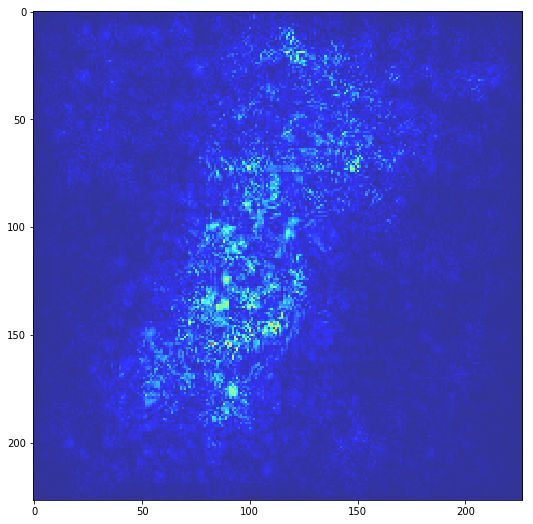

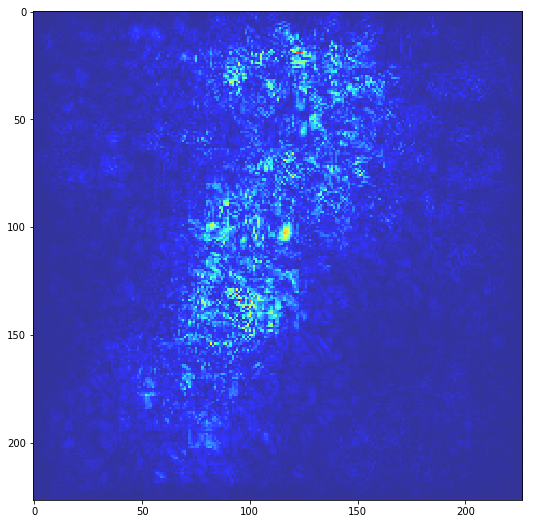

In [23]:
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_saliency(model,
                               layer_idx,
                               filter_indices = class_idx,
                               seed_input     = img[np.newaxis,...])
    plot_map(grads)

In [24]:
print(ana,ina)

(0, 8)


In [37]:
%time
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']
for label in [ana,ina]:
    layer_info[label] = {}
    for layer in [1,2,3,4,5,6,7]:
        if layer == 1:
            start = 0
            end = 290400
        elif layer == 2:
            start = 290400
            end = 477024
        elif layer == 3:
            start = 477024
            end = 541920
        elif layer == 4:
            start = 541920
            end = 606816
        elif layer == 5:
            start = 606816
            end = 650080
        elif layer == 6:
            start = 650080
            end = 654176
        elif layer == 7:
            start = 654177
            end = 658272
    
        layer_info[label][layer] = {}
     
        #No lesion
        #print('No-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)

        pred = clf.predict(X_new)
        lambda_mask = np.ones(shape=((658272,)))
       

        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
        model.compile(optimizer=sgd, loss='mse')

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'rb') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image(im_valid_test,227,227, color_mode="bgr")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error)
              
            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Layer: ',layer,'Label: ', label,start,end)
        print('No lesion: ',dprime)
        layer_info[label][layer]['no'] = dprime
        
        
        #Before lesion
        #print('Pre-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)

        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((658272,)))
        lambda_mask[loc_new] = 0.
        print('pre-loc', len(loc_new))
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
        model.compile(optimizer=sgd, loss='mse')

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'rb') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image(im_valid_test,227,227, color_mode="bgr")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error)

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Cluster Only: ',dprime)
        layer_info[label][layer]['pre'] = dprime   
             

        #After Lesion
       # print('Post-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)
        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            temp2 = temp[np.asarray(np.where((temp <end) & (temp >=start))[0])]
            #print(len(temp), len(temp2))
            loc_new.extend(temp2)


        lambda_mask = np.ones(shape=((658272,)))
        lambda_mask[loc_new] = 0.
        print('post-loc', len(loc_new))
        model=None
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
        model.compile(optimizer=sgd, loss='mse')

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'rb') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image(im_valid_test,227,227, color_mode="bgr")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error)

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Cluster - layer: ',dprime)
        layer_info[label][layer]['post'] = dprime
        
        
         #Random Lesion
       # print('Post-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)
        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            temp2 = temp[np.asarray(np.where((temp >end) | (temp <=start))[0])]
            #print(len(temp), len(temp2))
            loc_new.extend(temp2)

        loc_new2 = np.random.randint(start,end,len(loc_new))
        lambda_mask = np.ones(shape=((658272,)))
        lambda_mask[loc_new2] = 0.
        print('post-rand-loc', len(loc_new))
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
        model.compile(optimizer=sgd, loss='mse')

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'rb') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image(im_valid_test,227,227, color_mode="bgr")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error)

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Random: ',dprime)
        layer_info[label][layer]['rand'] = dprime
       

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs
th
animate 32 39 0.179487179487 0.820512820513
inanimate 24 39 0.384615384615 0.615384615385
('Layer: ', 1, 'Label: ', 0, 0, 290400)
('No lesion: ', -0.20512820512820507)
('pre-loc', 87077)
th
animate 0 39 1.0 0.0
inanimate 21 39 0.461538461538 0.538461538462
('Cluster Only: ', 0.5384615384615384)
('post-loc', 33684)
th
animate 31 39 0.205128205128 0.794871794872
inanimate 24 39 0.384615384615 0.615384615385
('Cluster - layer: ', -0.1794871794871794)
('post-rand-loc', 53393)
th
animate 30 39 0.230769230769 0.769230769231
inanimate 24 39 0.384615384615 0.615384615385
('Random: ', -0.15384615384615385)
th
animate 32 39 0.179487179487 0.820512820513
inanimate 24 39 0.384615384615 0.615384615385
('Layer: ', 2, 'Label: ', 0, 290400, 477024)
('No lesion: ', -0.20512820512820507)
('pre-loc', 87077)
th
animate 0 39 1.0 0.0
inanimate 21 39 0.461538461538 0.538461538462
('Cluster Only: ', 0.5384615384615384)
('post-loc', 18447)
th
an

('post-rand-loc', 99637)
th
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
('Random: ', 0.0)


In [38]:
X = np.arange(1,8)
for item in X:
    print(item,layer_info[ana][item]['post'],layer_info[ana][item]['rand'])

(1, -0.1794871794871794, -0.15384615384615385)
(2, -0.15384615384615385, -0.2564102564102564)
(3, 0.28205128205128205, -0.1794871794871794)
(4, 0.10256410256410264, -0.10256410256410264)
(5, 0.1282051282051282, -0.05128205128205121)
(6, -0.20512820512820507, 0.0)
(7, -0.20512820512820507, 0.0)


(1, 0.5384615384615384, -0.1794871794871794, -0.15384615384615385, -0.20512820512820507)
(2, 0.5384615384615384, -0.15384615384615385, -0.2564102564102564, -0.20512820512820507)
(3, 0.5384615384615384, 0.28205128205128205, -0.1794871794871794, -0.20512820512820507)
(4, 0.5384615384615384, 0.10256410256410264, -0.10256410256410264, -0.20512820512820507)
(5, 0.5384615384615384, 0.1282051282051282, -0.05128205128205121, -0.20512820512820507)
(6, 0.5384615384615384, -0.20512820512820507, 0.0, -0.20512820512820507)
(7, 0.5384615384615384, -0.20512820512820507, 0.0, -0.20512820512820507)


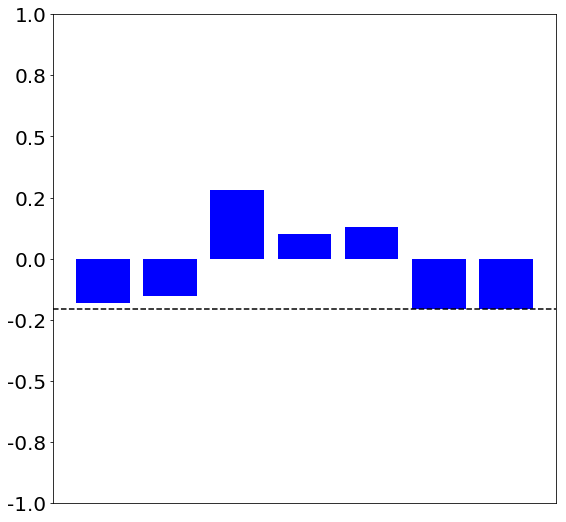

In [46]:
X = np.arange(1,8)
Y = []
Z =[]
P =[]
tmp = 0.
for item in X:
    print(item,layer_info[ana][item]['pre'],layer_info[ana][item]['post'],layer_info[ana][item]['rand'], layer_info[ana][item]['no'])
    P.append(layer_info[ana][item]['pre'])
    Y.append(layer_info[ana][item]['post'])
    Z.append(layer_info[ana][item]['rand'])

fig, ax = plt.subplots(figsize=(9,9))
plt.axhline(y=layer_info[ana][item]['no'] , color='black', linestyle='--')
plt.ylim([-1,1])
plt.bar(X,Y,color='b')
plt.xticks([])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
#plt.bar(X,Z)
#plt.bar(X,P)
plt.savefig('../../results/ana_layer_lesion.png', format='png',dpi=500, bbox_inches = "tight")

(1, -0.5641025641025641, -0.1794871794871794, -0.15384615384615385, -0.20512820512820507)
(2, -0.5641025641025641, -0.23076923076923084, -0.20512820512820507, -0.20512820512820507)
(3, -0.5641025641025641, -0.3076923076923078, -0.02564102564102566, -0.20512820512820507)
(4, -0.5641025641025641, -0.28205128205128205, -0.1282051282051282, -0.20512820512820507)
(5, -0.5641025641025641, -0.28205128205128205, 0.0, -0.20512820512820507)
(6, -0.5641025641025641, -0.20512820512820507, 0.0, -0.20512820512820507)
(7, -0.5641025641025641, -0.20512820512820507, 0.0, -0.20512820512820507)


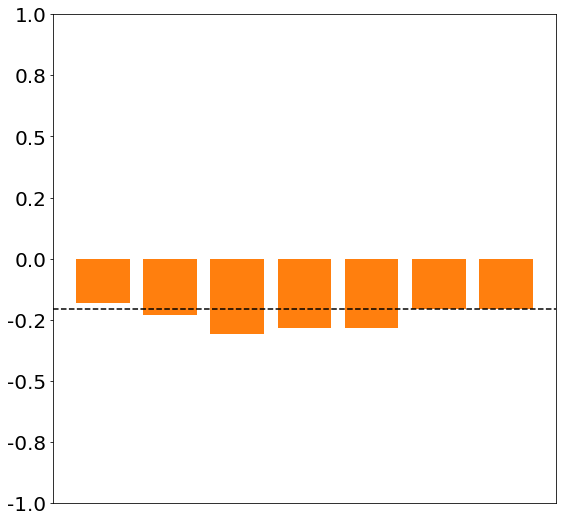

In [45]:
X = np.arange(1,8)
Y = []
Z =[]
P =[]
tmp = 0.
for item in X:
    print(item,layer_info[ina][item]['pre'],layer_info[ina][item]['post'],layer_info[ina][item]['rand'], layer_info[ina][item]['no'])
    P.append(layer_info[ina][item]['pre'])
    Y.append(layer_info[ina][item]['post'])
    Z.append(layer_info[ina][item]['rand'])

fig, ax = plt.subplots(figsize=(9,9))
plt.axhline(y=layer_info[ina][item]['no'] , color='black', linestyle='--')
plt.ylim([-1,1])
plt.bar(X,Y,color='C1')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
#plt.bar(X,Z)
#plt.bar(X,P)
plt.xticks([])
plt.savefig('../../results/ina_layer_lesion.png', format='png',dpi=500, bbox_inches = "tight")

In [148]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    #print(len(rects))
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width(), height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='top')

Text(0.5,1,'Neurons from the animate cluster')

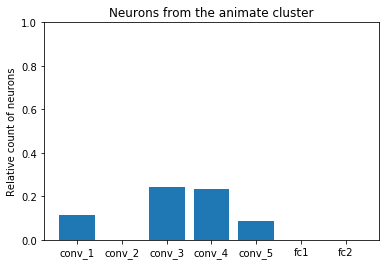

In [25]:
label_loc = np.where(pred==ana)[0]
Z = []
for i in range(len(label_loc)):
    temp = np.where(pred_kmeans==label_loc[i])[0]
    for i in temp:
        Z.append(i)
X = np.arange(7)
Y = np.zeros((7,))

for i in Z:
    if i in range(0,290400): 
        Y[0] += 1
    elif i in range(290400,477024):
        Y[1] += 1
    elif i in range(477024,541920):
        Y[2] += 1
    elif i in range(541920,606816):
        Y[3] += 1
    elif i in range(606816,650080):
        Y[4] += 1
    elif i in range(650080,654176):
        Y[5] += 1
    elif i in range(654176,658272):
        Y[6] += 1
    else:
        print i


Y[0] = float(Y[0]) /290400
Y[1] = float(Y[0]) / 196624
Y[2] = float(Y[2]) / 64896
Y[3] = float(Y[3]) / 64896
Y[4] = float(Y[4]) /43264
Y[5] = float(Y[5]) /4096
Y[6] = float(Y[6]) /4096

plt.ylim([0,1.])
rect = plt.bar(X,Y)
plt.xticks(X, ('conv_1', 'conv_2', 'conv_3', 'conv_4','conv_5','fc1','fc2'))
plt.ylabel('Relative count of neurons')
plt.title('Neurons from the animate cluster')
#autolabel(rect)
#plt.savefig('../../results/scree/'+str(method)+'_results_ana_hist_alt.png', format='png')

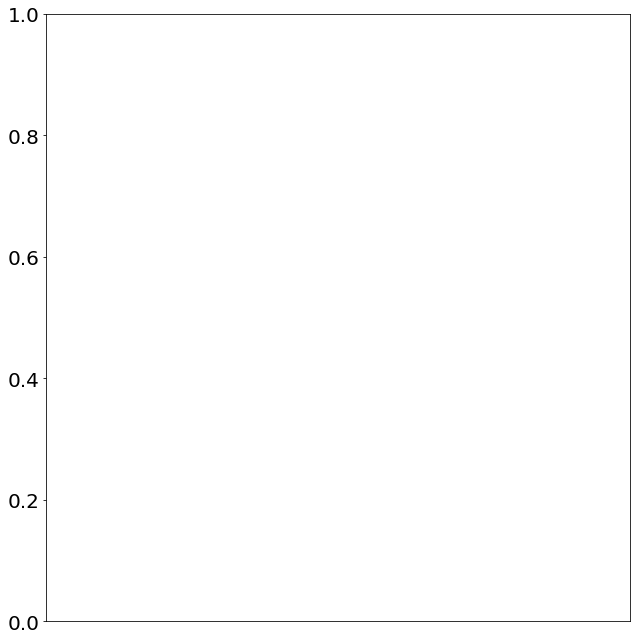

In [41]:
fig, ax = plt.subplots(figsize=(9,9))
plt.ylim([0,1.])
rect = plt.bar(X,Y,color='b')
plt.xticks([])
#plt.ylabel('Relative count of neurons')
#plt.title('Neurons from the animate cluster')
#plt.axis('off')
#autolabel(rect)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.tight_layout()
plt.savefig('../../results/ana_hist_alt.png', format='png', bbox_inches = "tight")

Text(0.5,1,'Neurons from the animate cluster')

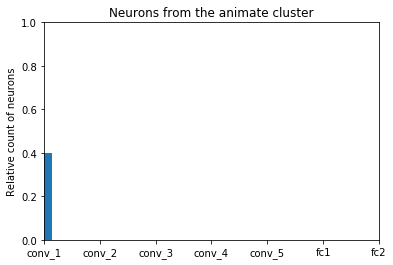

In [27]:
label_loc = np.where(pred==ina)[0]
Z1 = []
for i in range(len(label_loc)):
    temp = np.where(pred_kmeans==label_loc[i])[0]
    for i in temp:
        Z1.append(i)
X1 = np.arange(7)
Y1 = np.zeros((7,))

for i in Z1:
    if i in range(0,290400): 
        Y1[0] += 1
    elif i in range(290400,477024):
        Y1[1] += 1
    elif i in range(477024,541920):
        Y1[2] += 1
    elif i in range(541920,606816):
        Y1[3] += 1
    elif i in range(606816,650080):
        Y1[4] += 1
    elif i in range(650080,654176):
        Y1[5] += 1
    elif i in range(654176,658272):
        Y1[6] += 1
    else:
        print i

Y1[0] = float(Y1[0]) /290400
Y1[1] = float(Y1[0]) / 196624
Y1[2] = float(Y1[2]) / 64896
Y1[3] = float(Y1[3]) / 64896
Y1[4] = float(Y1[4]) /43264
Y1[5] = float(Y1[5]) /4096
Y1[6] = float(Y1[6]) /4096

plt.ylim([0,1.])
rect = plt.barh(X1,Y1)
plt.xticks(X1, ('conv_1', 'conv_2', 'conv_3', 'conv_4','conv_5','fc1','fc2'))
plt.ylabel('Relative count of neurons')
plt.title('Neurons from the animate cluster')
#autolabel(rect)
#plt.savefig('../../results/scree/'+str(method)+'_results_ana_hist_alt.png', format='png')

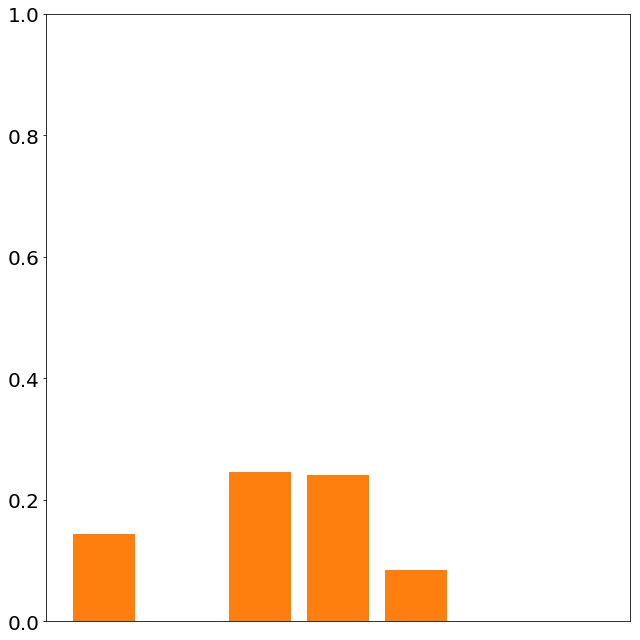

In [36]:
fig, ax = plt.subplots(figsize=(9,9))
plt.ylim([0,1.])
rect = plt.bar(X1,Y1,color='C1')
plt.xticks([])
#plt.ylabel('Relative count of neurons')
#plt.title('Neurons from the inanimate cluster')
#plt.axis('off')
#autolabel(rect)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.tight_layout()
plt.savefig('../../results/ina_hist_alt.png', format='png', bbox_inches = "tight")

In [152]:
X,Y,X1,Y1

(array([0, 1, 2, 3, 4, 5, 6]),
 array([1.15991736e-01, 5.89916468e-07, 2.44421844e-01, 2.35268738e-01,
        8.80870932e-02, 1.22070312e-03, 0.00000000e+00]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([1.44459366e-01, 7.34698543e-07, 2.44991987e-01, 2.41185897e-01,
        8.50360577e-02, 1.22070312e-03, 0.00000000e+00]))